# Fruit Inspection
Project for Computer Vision exam, University of Bologna
By Valentina Boriano (valentina.boriano@studio.unibo.it) and Pietro Fanti (pietro.fanti@studio.unibo.it)

## Task 1:  Fruit segmentation and edge detection
### Preliminary operations and images import

In [1]:
# Import libraries

import cv2
from matplotlib import pyplot as plt
import numpy as np
import statistics 

In [2]:
# Set some constants needed in the code

FILENAMES = ["000001","000002","000003"]
N = len(FILENAMES)

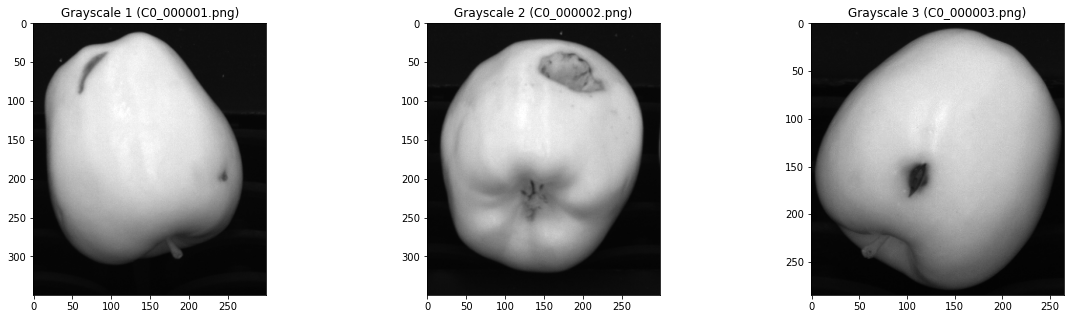

In [3]:
# Import grayscales images acquired through a NIR (Near Infra-Red)
# Then show them

grayscales = []
plt.figure(figsize=(20, 5))

for i, name in enumerate(FILENAMES):
    img = cv2.imread("img/first task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales.append(img)
    plt.subplot(1,N,i+1)
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

### Fruit segmentation

At first, we want to obtain a binary mask of the fruit for each image, then we will put in evidence imperfections through a floof-fill approach.
In order to do this we will plot the pixel value histogram of each image to see if a thresheold can be easily determined.

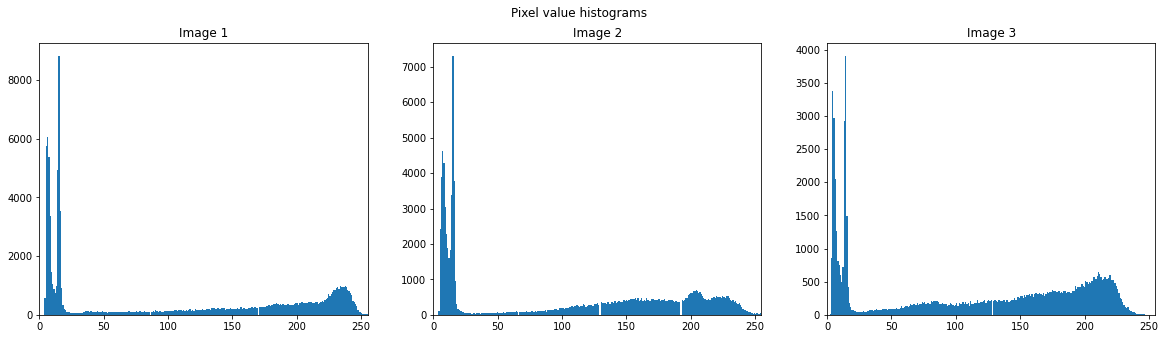

In [4]:
# Plot pixel value histogram of img
def plot_histogram(img, i):
    # flatten to 1D array
    vals = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])



fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales):
    plot_histogram(img, i)
fig.suptitle("Pixel value histograms")
plt.show()

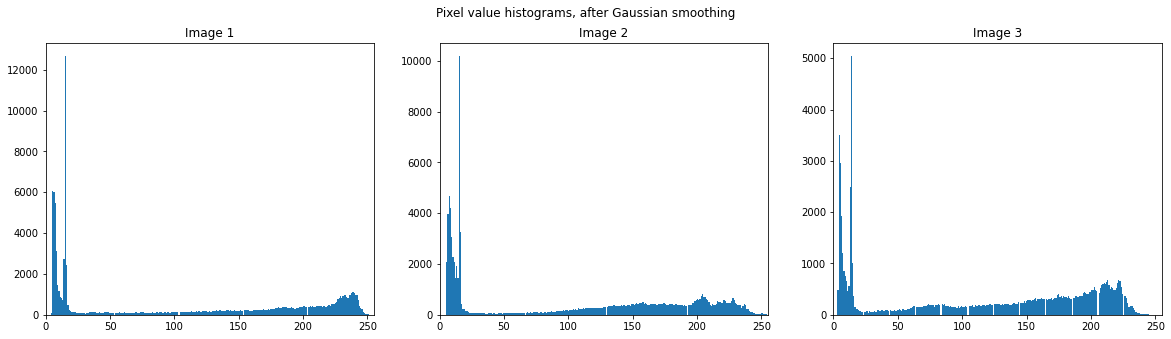

In [5]:
blurred = []
fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales):
    blur = cv2.GaussianBlur(img,(5,5),0)
    blurred.append(blur)
    plot_histogram(blur, i)
fig.suptitle("Pixel value histograms, after Gaussian smoothing")
plt.show()

It is not possible to determine a threshold from the histogram for any of the images, so we need a less naive approach. __Otsu's algorithm__ allow us to obtain the optimal threshold (the one which minimizes the _Within-group Variance_)

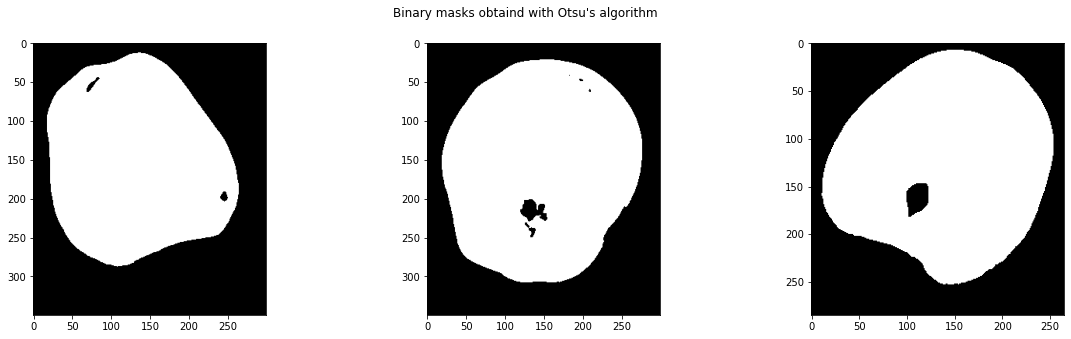

In [6]:
masks = []

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(blurred):
    ret, mask = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    plt.subplot(1,N,i+1)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

Now we empirically assume that the left-top corner pixel will always belong to the background, so we can __flood-fill images with seed (0,0)__ to separate the background from the blobs inside fruits

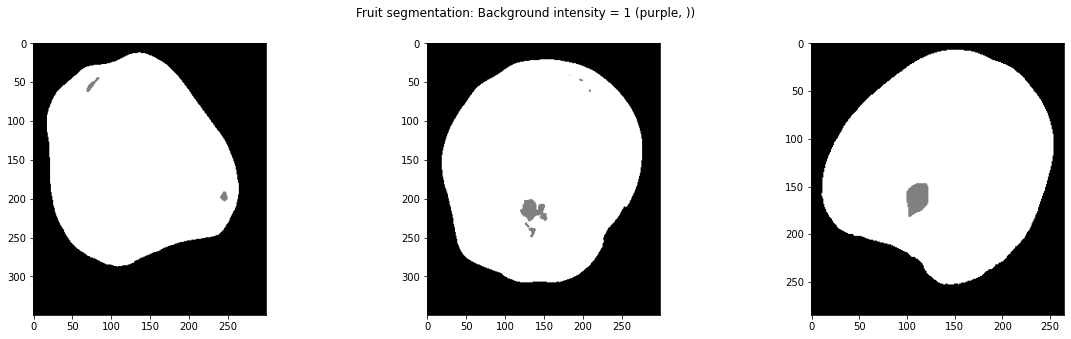

In [7]:
ff_masks = []

fig = plt.figure(figsize=(20,5))
for i, m in enumerate(masks):
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    ff_m = m + 1
    cv2.floodFill(ff_m, None, (0,0), 0)
    ff_masks.append(ff_m)
    plt.subplot(1,N,i+1)
    plt.imshow(ff_m, cmap="gray", vmin=0, vmax=2)
fig.suptitle("Fruit segmentation: Background intensity = 1 (purple, ))")
plt.show()

Now each image contains information about where the background, the fruit and the "imperfections" are. However in the second image the calyx is classified as an imperfection and the real imperfection, which is lighter than the calyx, is barely visible.
We hope to obtain better results with an edge detection approach.

### Edge detection
To do edge detection we have used Canny's algorithm, which take as parameters two thresholds.
We have tried with differents couple of values (and we have tried to use Gaussian blurred images as well) without find out obtain a perfect and fixed couple which gave perfect results for all the images: with low values the calyx in the second image is detected as-well (__false positive__), on the other hand, with higher values, the calyx disappears, but in the first image the smaller imperfection disappears too (__false negative__).

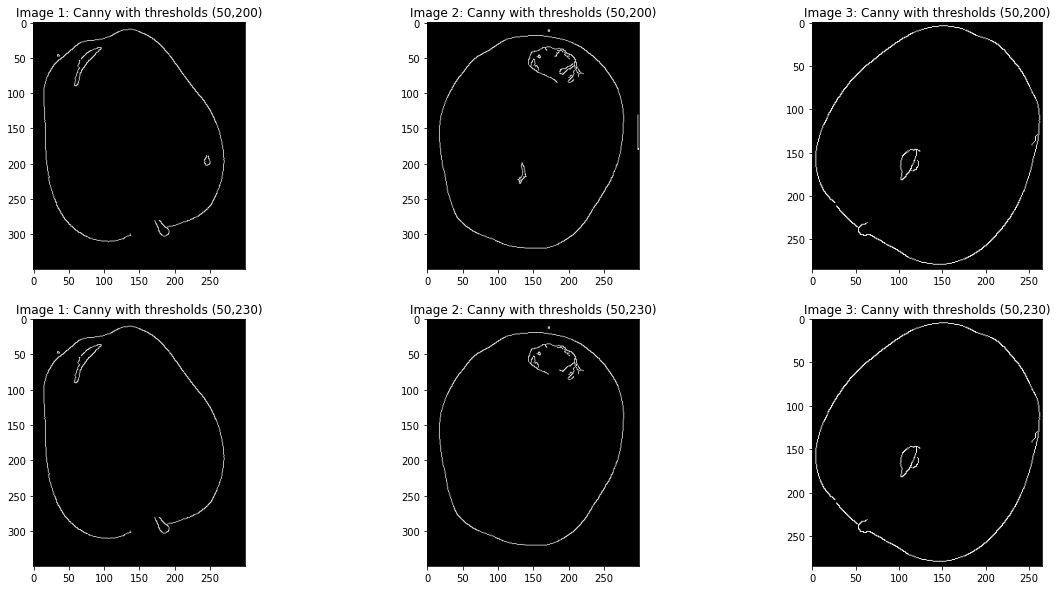

In [8]:
edges_high = []
edges_low = []

plt.figure(figsize=(20,10))
for i, img in enumerate(grayscales):
    edge = cv2.Canny(img, 50, 200)
    edges_low.append(edge)
    plt.subplot(2, N, i+1)
    plt.title("Image {0}: Canny with thresholds (50,200)".format(i+1))
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
    edge = cv2.Canny(img, 50, 230)
    edges_high.append(edge)
    plt.subplot(2, N, i+N+1)
    plt.title("Image {0}: Canny with thresholds (50,230)".format(i+1))
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
plt.show()

We have decided to keep the couple of thresholds that generates false negative, rather than the one that generates false positive. Such decision is motivated by the nature of the problem itself: every apple has a calyx.

So, only the results obtained with the couple _(50,230)_ is used for the following operations.

We now use the masks obtained before to eliminate the edges of the apples and only leave imperfections' edges

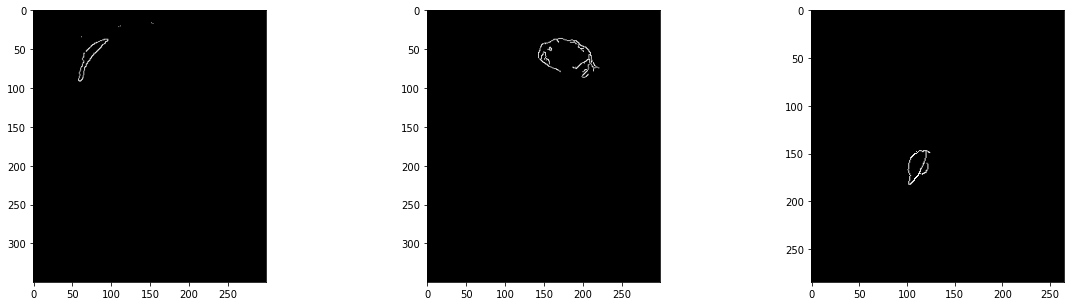

In [9]:
edges = edges_high

plt.figure(figsize=(20,5))
for i, mask in enumerate(ff_masks):
    # We have setted background to 0, so a pixelwise multiplication is sufficient
    edge = edges[i] * mask
    edges[i] = edge
    plt.subplot(1,N,i+1)
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
plt.show()

### Show results on colored images

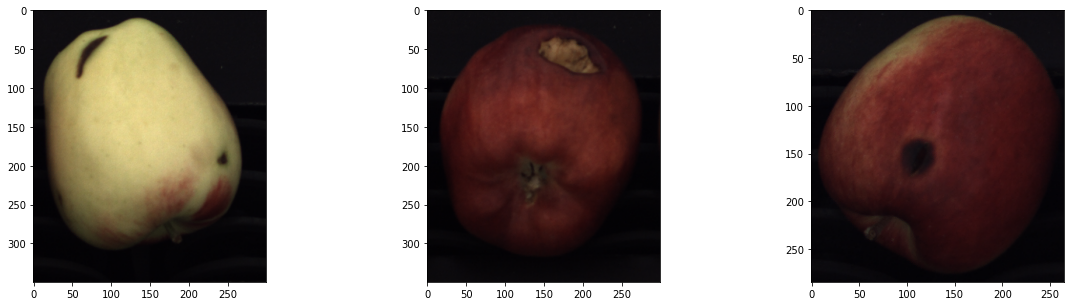

In [10]:
rgb_imgs = []
plt.figure(figsize=(20, 5))
for i, name in enumerate(FILENAMES):
    img_bgr = cv2.imread("img/first task/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb_imgs.append(img_rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(img_rgb)
plt.show()

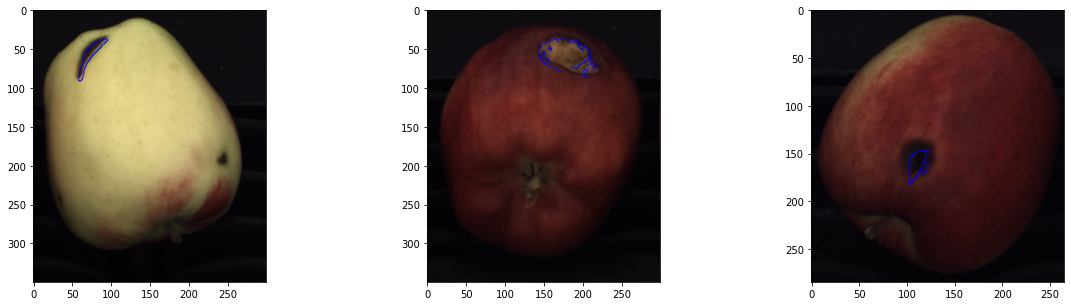

In [11]:
results = []
plt.figure(figsize=(20, 5))
for i, rgb in enumerate(rgb_imgs):
    m, n, _ = rgb.shape
    for j in range(m):
        for k in range(n):
            if edges[i][j,k] != 0:
                rgb[j,k,0] = 0
                rgb[j,k,1] = 0
                rgb[j,k,2] = 255
    results.append(rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb)
plt.show()

Imperfection detected are marked in blue

## Task 2: Russet detection
Images import

In [12]:
FILENAMES2 = ["000004","000005"]
N2 = len(FILENAMES2)

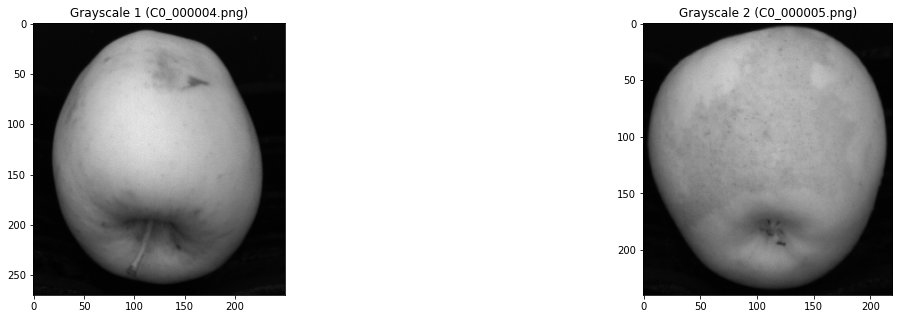

In [13]:
grayscales2 = []
plt.figure(figsize=(20, 5))

for i, name in enumerate(FILENAMES2):
    img = cv2.imread("img/second task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales2.append(img)
    plt.subplot(1,N2,i+1)
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

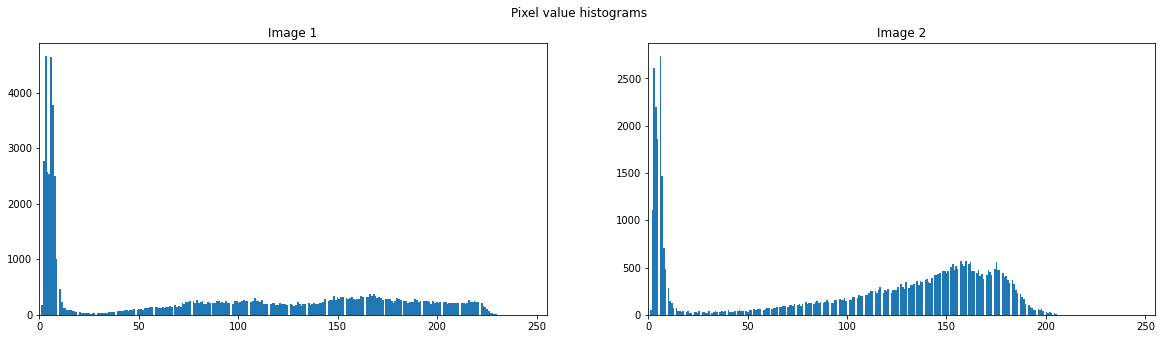

In [14]:
fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales2):
    # flatten to 1D array
    vals = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N2,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
fig.suptitle("Pixel value histograms")
plt.show()

We made the histogram to better use the global thresholding to assign to all pixels with values below the threshold T. The threshold T = 40 was selected as the minimum between two modes on a histogram, where pixels with intensity values higher than 40 are shown in white. 

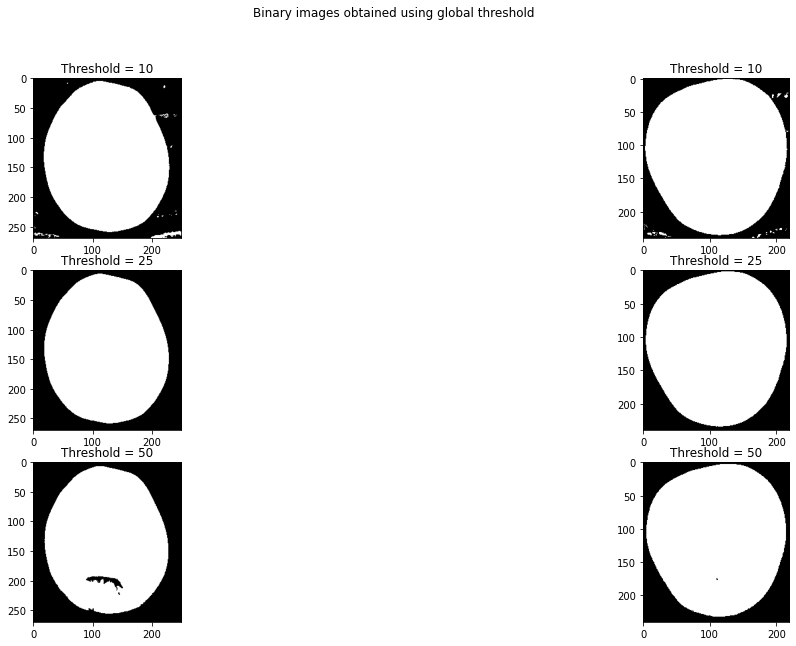

In [15]:
masks2 = []
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(grayscales2):
    # TODO per Vale: spiegare come si è ottenuto threshold uguale a 40 (osservazione istogramma + tentativi),
    # mostrare i risultati con altre threshold, spiegare perché otsu non va bene (il bg "mangia" il fg)
    # aggiungere i titolo al grafico
    ret,thresh = cv2.threshold(img, 10, 1, cv2.THRESH_BINARY)
    ret,thresh1 = cv2.threshold(img, 25, 1, cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(img, 50, 1, cv2.THRESH_BINARY)
    masks2.append(thresh1)
    
    a = fig.add_subplot(3,2, i+1)
    a.set_title('Threshold = 10')
    plt.imshow(thresh, 'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,2,i+3)
    a.set_title('Threshold = 25')
    plt.imshow(thresh1 ,'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,2,i+5)
    a.set_title('Threshold = 50')
    plt.imshow(thresh2 , 'gray' ,vmin=0, vmax=1)
fig.suptitle("Binary images obtained using global threshold")
plt.show()


We also tried to use otsu algorithm but the generated mask we can see that part of the foreground 
has the same color as the background. For this reason we decided to utilize global thresholding.

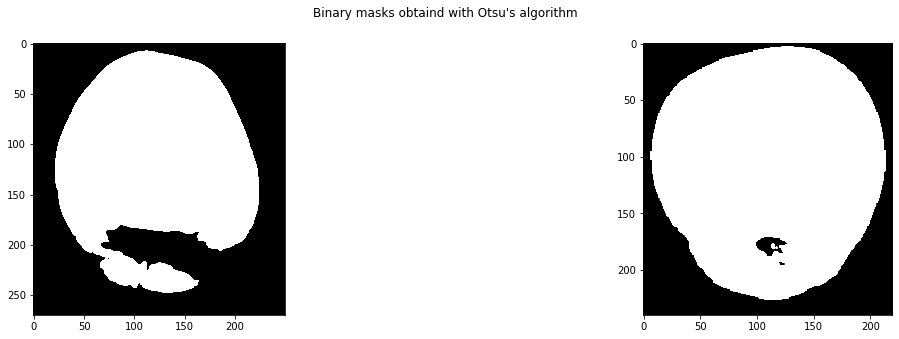

In [16]:
otsu_masks = []

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales2):
    # (1,1) => no blur
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret, mask = cv2.threshold(blur, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsu_masks.append(mask)
    plt.subplot(1,N2,i+1)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

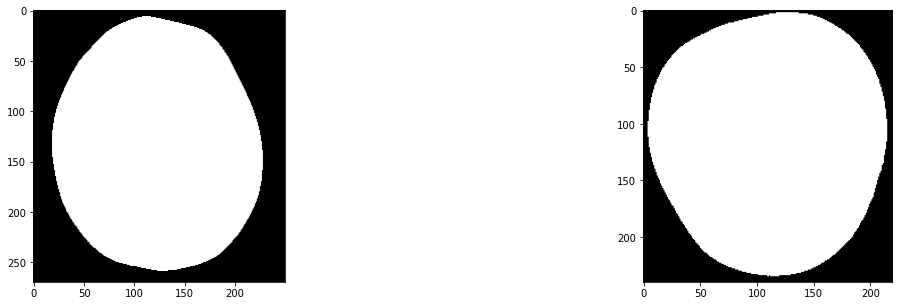

In [17]:
#Flood-fill
ff_masks2 = []
fig = plt.figure(figsize=(20, 5))
for k, mask in enumerate(masks2):
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    ff_m = mask + 1
    cv2.floodFill(ff_m, None, (0,0), 0)
    m, n = ff_m.shape
    for i in range(m):
        for j in range(n):
            if ff_m[i,j] == 2:
                ff_m[i,j] = 1
    ff_masks2.append(ff_m)
    plt.subplot(1,2,k+1)
    plt.imshow(ff_m, cmap='gray', vmin=0, vmax=1)
plt.show()

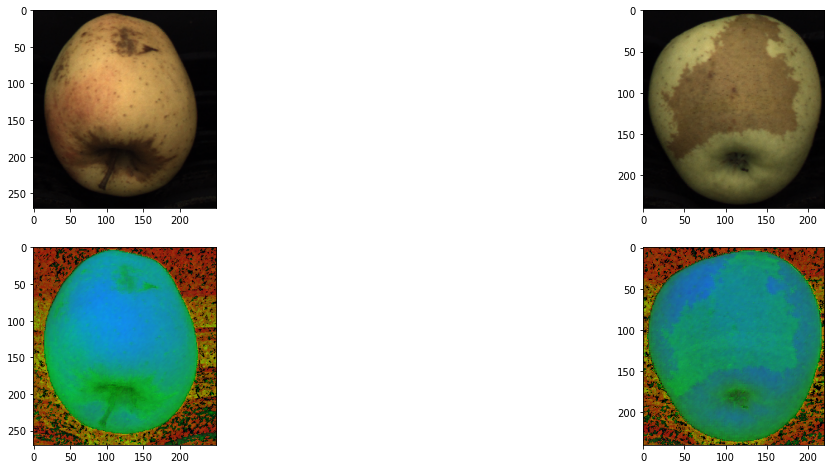

In [18]:
rgb_2 = []
hsv_imgs = []
plt.figure(figsize=(20, 8))
for i, name in enumerate(FILENAMES2):
    img_bgr = cv2.imread("img/second task/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    rgb_2.append(img_rgb)
    hsv_imgs.append(img_hsv)
    plt.subplot(2,N2,i+1)
    plt.imshow(rgb_2[i])
    plt.subplot(2,N2,i+3)
    plt.imshow(hsv_imgs[i])
plt.show()

In [86]:
results_2 = []
image_rgb = []
plt.figure(figsize=(20, 5))
for i, rgb in enumerate(rgb_2):
    m, n, _ = rgb.shape
    result = []
    for j in range(m):
        for k in range(n):
            if masks2[i][j,k] != 0:
                if any(rgb_2[i][j,k,0:3]):
                    result.append(rgb[j,k,:])
            else:
                rgb[j,k,0] = masks2[i][j,k]
                rgb[j,k,1] = masks2[i][j,k]
                rgb[j,k,2] = masks2[i][j,k]
    image_rgb.append(rgb)
    result = np.array(result)
    results_2.append(result)
    
results_hsv = []
image_hsv = []
plt.figure(figsize=(20, 5))
for i, hsv in enumerate(hsv_imgs):
    m, n, _ = hsv.shape
    result_hsv = []
    for j in range(m):
        for k in range(n):
            if masks2[i][j,k] != 0:
                if any(rgb_2[i][j,k,0:3]):
                    result_hsv.append(hsv[j,k,:])
            else:
                hsv[j,k,0] = masks2[i][j,k]
                hsv[j,k,1] = masks2[i][j,k]
                hsv[j,k,2] = masks2[i][j,k]
    image_hsv.append(hsv)
    result_hsv = np.array(result_hsv)
    results_hsv.append(result_hsv)
"""    
results_3 = []
plt.figure(figsize=(20, 5))
for i, rgb in enumerate(rgb_2):
    m, n, _ = rgb.shape
    for j in range(m):
        for k in range(n):
            if ff_masks2[i][j,k] == 0:
                rgb[j,k,0] = ff_masks2[i][j,k]
                rgb[j,k,1] = ff_masks2[i][j,k]
                rgb[j,k,2] = ff_masks2[i][j,k]
    results_3.append(rgb)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb)
""";

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [109]:
color_means_russet = [132,105,161]
color_means = []
inverse_cov = []
for i, rgb in enumerate(results_2):
    n, channels = rgb.shape
    means = []
    for j in range(channels):
        mean = np.mean(rgb[:,j])
        means.append(mean)
    cov = []
    for array_i, mean_i in zip(rgb, means):
        for array_j, mean_j in zip(rgb, means):
            cov_ij = np.sum((array_i - mean_i) * (array_j - mean_j))/n
            cov.append(cov_ij)
    cov = np.array(cov)
    cov = cov.reshape(3,3)
    cov = np.linalg.inv(cov) #inverse of covariance matrix
    inverse_cov.append(cov)
    color_means.append(means) #means of rgb colors of each image
inverse_cov = np.array(inverse_cov) 

#hsv

color_means_hsv = []
inverse_cov_hsv = []
for i, hsv in enumerate(results_hsv):
    n, channels = hsv.shape
    means_hsv = []
    for j in range(channels):
        mean_hsv = np.mean(rgb[:,j])
        means_hsv.append(mean_hsv)
    cov_hsv = []
    for array_i, mean_i in zip(hsv, means_hsv):
        for array_j, mean_j in zip(hsv, means_hsv):
            cov_ij_hsv = np.sum((array_i - mean_i) * (array_j - mean_j))/n
            cov_hsv.append(cov_ij_hsv)
    cov_hsv = np.array(cov_hsv)
    cov_hsv = cov_hsv.reshape(3,3)
    cov_hsv = np.linalg.inv(cov_hsv) #inverse of covariance matrix
    inverse_cov_hsv.append(cov_hsv)
    color_means_hsv.append(means_hsv) #means of rgb colors of each image
inverse_cov_hsv = np.array(inverse_cov_hsv) 

In [110]:
#rgb
dist_m = []
image_apple_0 = []
k_ind_0= []
l_ind_0 = []
dist_m_russet_0 = []
#hsv
dist_m_hsv = []
image_apple_0_hsv = []
k_ind_0_hsv= []
l_ind_0_hsv = []
dist_m_russet_0_hsv = []
m,n,channels = image_rgb[0].shape 
for k in range (0,m):
    for l in range(0,n):  
        if any(image_rgb[0][k,l,0:3]): #with this condition we can consider only the apple without the background
            image_apple_0.append(image_rgb[0][k,l,0:3])
            k_ind_0.append(k)
            l_ind_0.append(l)
            #mahalanobis distance rgb with mean color of the image
            dist_m.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_rgb[0][k,l,0:3] , color_means[0]).reshape(1,-1) ,inverse_cov[0]), np.subtract(image_rgb[0][k,l,0:3] , color_means[0]))))) 
            #mahalanobis distance rgb with mean color of the russet
            dist_m_russet_0.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_rgb[0][k,l,0:3] , color_means_russet).reshape(1,-1) ,inverse_cov[0]), np.subtract(image_rgb[0][k,l,0:3] , color_means_russet))))) 
        
        if any(image_hsv[0][k,l,0:3]): #with this condition we can consider only the apple without the background
            image_apple_0_hsv.append(image_hsv[0][k,l,0:3])
            k_ind_0_hsv.append(k)
            l_ind_0_hsv.append(l)
            #mahalanobis distance hsv with mean color of the image
            dist_m_hsv.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_hsv[0][k,l,0:3] , color_means_hsv[0]).reshape(1,-1) ,inverse_cov_hsv[0]), np.subtract(image_hsv[0][k,l,0:3] , color_means_hsv[0]))))) 
            #mahalanobis distance rgb with mean color of the russet
            dist_m_russet_0_hsv.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_hsv[0][k,l,0:3] , color_means_russet).reshape(1,-1) ,inverse_cov[0]), np.subtract(image_hsv[0][k,l,0:3] , color_means_russet))))) 
    
mahala_0 = np.array(dist_m)
mean_0 = mahala_0.mean()
mahala_0_russet = np.array(dist_m_russet_0)
mean_0_russet = mahala_0_russet.mean()
image_apple_0 = np.array(image_apple_0)
print("mahalanobis distance rgb: \n", mahala_0)
print("\n mean of mahalanobis distance rgb: \n", mean_0)

print("\n mahalanobis distance rgb with mean of russet's color: \n", mahala_0_russet)
print("\n mean of mahalanobis distance rgb with mean of russet's color: \n", mean_0_russet)

mahala_0_hsv = np.array(dist_m_hsv)
mean_0_hsv = mahala_0_hsv.mean()
mahala_0_russet_hsv = np.array(dist_m_russet_0_hsv)
mean_0_russet_hsv = mahala_0_russet_hsv.mean()
image_apple_0_hsv = np.array(image_apple_0_hsv)

print("\n mahalanobis distance hsv: \n", mahala_0_hsv)
print("\n mean of mahalanobis distance hsv: \n", mean_0_hsv)

print("\n mahalanobis distance hsv with mean of russet's color: \n", mahala_0_russet_hsv)
print("\n mean of mahalanobis distance hsv with mean of russet's color: \n", mean_0_russet_hsv)

mahalanobis distance rgb: 
 [[ 280.40916465]
 [ 989.27763944]
 [1392.99389245]
 ...
 [ 453.95156042]
 [ 453.95156042]
 [ 453.95156042]]

 mean of mahalanobis distance rgb: 
 3248.5094085354744

 mahalanobis distance rgb with mean of russet's color: 
 [[25715.14555561]
 [25004.5476728 ]
 [24600.84140786]
 ...
 [26281.62566686]
 [26281.62566686]
 [26281.62566686]]

 mean of mahalanobis distance rgb with mean of russet's color: 
 25994.102039062793

 mahalanobis distance hsv: 
 [[8783.23804607]
 [9050.22932749]
 [9012.04393776]
 ...
 [2542.4902684 ]
 [2542.4902684 ]
 [2542.4902684 ]]

 mean of mahalanobis distance hsv: 
 8994.784845453292

 mahalanobis distance hsv with mean of russet's color: 
 [[85336.53732649]
 [87734.65597834]
 [87150.42472057]
 ...
 [24758.20225217]
 [24758.20225217]
 [24758.20225217]]

 mean of mahalanobis distance hsv with mean of russet's color: 
 88121.34071544105


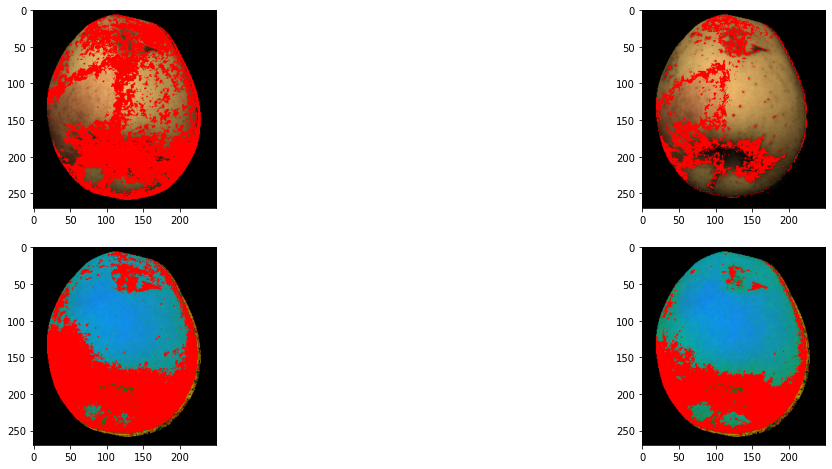

In [123]:
plt.figure(figsize=(20, 8))
m,n = mahala_0.shape
image_rgb_apple = image_rgb[0].copy()
image_rgb_apple_hsv = image_hsv[0].copy()
image_rgb_apple_russet = image_rgb[0].copy()
image_rgb_apple_russet_hsv = image_hsv[0].copy()
for j in range(0,m):
    if mahala_0[j,0]<mean_0:
        image_rgb_apple[k_ind_0[j],l_ind_0[j],0:3] = [255,0,0]
    if ((mahala_0_russet[j,0] < 25000) and (mahala_0_russet[j,0] > 21000)):
        image_rgb_apple_russet[k_ind_0[j],l_ind_0[j],0:3] = [255, 0, 0]
    if mahala_0_hsv[j,0] > mean_0_hsv:
        image_rgb_apple_hsv[k_ind_0_hsv[j],l_ind_0_hsv[j],0:3] = [255,0,0]
    if mahala_0_russet_hsv[j,0] > 100000:
        image_rgb_apple_russet_hsv[k_ind_0_hsv[j],l_ind_0_hsv[j],0:3] = [255,0,0]
plt.subplot(2,2,1)
plt.imshow(image_rgb_apple)
plt.subplot(2,2,2)
plt.imshow(image_rgb_apple_russet)
plt.subplot(2,2,3)
plt.imshow(image_rgb_apple_hsv)
plt.subplot(2,2,4)
plt.imshow(image_rgb_apple_russet_hsv)
plt.show()

In [124]:
#rgb
dist_m = []
dist_m_russet = []
image_apple = []
k_ind= []
l_ind = []
#hsv
dist_m_hsv = []
dist_m_russet_hsv = []
image_apple_hsv = []
k_ind_hsv= []
l_ind_hsv = []
m,n,channels = image_rgb[1].shape 
for k in range (0,m):
    for l in range(0,n):  
        if any(image_rgb[1][k,l,0:3]): #with this condition we can consider only the apple without the background
            image_apple.append(image_rgb[1][k,l,0:channels])
            k_ind.append(k) 
            l_ind.append(l)
            #mahalanobis distance
            dist_m.append(np.sqrt(np.matmul(np.matmul(np.subtract(image_rgb[1][k,l,0:3] , color_means[1]).reshape(1,-1) ,inverse_cov[1]), np.subtract(image_rgb[1][k,l,0:3] , color_means[1]))))
            #mahalanobis distance rgb with mean color of the russet
            dist_m_russet.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_rgb[1][k,l,0:3] , color_means_russet).reshape(1,-1) ,inverse_cov[1]), np.subtract(image_rgb[1][k,l,0:3] , color_means_russet))))) 
        if any(image_hsv[1][k,l,0:3]): #with this condition we can consider only the apple without the background
            image_apple_hsv.append(image_hsv[1][k,l,0:3])
            k_ind_hsv.append(k)
            l_ind_hsv.append(l)
            #mahalanobis distance hsv
            dist_m_hsv.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_hsv[1][k,l,0:3] , color_means_hsv[1]).reshape(1,-1) ,inverse_cov_hsv[1]), np.subtract(image_hsv[1][k,l,0:3] , color_means_hsv[1]))))) 
            #mahalanobis distance hsv with mean color of the russet
            dist_m_russet_hsv.append(np.sqrt((np.matmul(np.matmul(np.subtract(image_hsv[1][k,l,0:3] , color_means_russet).reshape(1,-1) ,inverse_cov[1]), np.subtract(image_hsv[1][k,l,0:3] , color_means_russet))))) 
mahala = np.array(dist_m)
mean = mahala.mean()
mahala_russet = np.array(dist_m_russet)
mean_russet = mahala_0_russet.mean()
image_apple = np.array(image_apple)

print("mahalanobis distance rgb: \n", mahala)
print("\n mean of mahalanobis distance rgb: \n", mean)

print("\n mahalanobis distance rgb with mean of russet's color: \n", mahala_russet)
print("\n mean of mahalanobis distance rgb with mean of russet's color: \n", mean_russet)

mahala_hsv = np.array(dist_m_hsv)
mean_hsv = mahala_hsv.mean()
mahala_russet_hsv = np.array(dist_m_russet_hsv)
mean_russet_hsv = mahala_russet_hsv.mean()
image_apple_hsv = np.array(image_apple_hsv)

print("\n mahalanobis distance hsv: \n", mahala_hsv)
print("\n mean of mahalanobis distance hsv: \n", mean_hsv)

print("\n mahalanobis distance hsv with mean of russet's color: \n", mahala_russet_hsv)
print("\n mean of mahalanobis distance hsv with mean of russet's color: \n", mean_russet_hsv)





mahalanobis distance rgb: 
 [[ 982.08310932]
 [ 722.38442388]
 [ 644.89658971]
 ...
 [ 975.63170797]
 [1026.88532553]
 [1135.18599167]]

 mean of mahalanobis distance rgb: 
 2490.212077932362

 mahalanobis distance rgb with mean of russet's color: 
 [[31203.40282889]
 [31506.90959695]
 [31638.32296556]
 ...
 [33044.76388599]
 [32866.64976391]
 [33127.686189  ]]

 mean of mahalanobis distance rgb with mean of russet's color: 
 25994.102039062793

 mahalanobis distance hsv: 
 [[2224.01587015]
 [2679.7628889 ]
 [2380.11641137]
 ...
 [4136.81732245]
 [3292.33865918]
 [3885.06877724]]

 mean of mahalanobis distance hsv: 
 3233.235213181518

 mahalanobis distance hsv with mean of russet's color: 
 [[38187.55907205]
 [39104.09495373]
 [39834.21776723]
 ...
 [59485.31717653]
 [53584.3780266 ]
 [57737.30390405]]

 mean of mahalanobis distance hsv with mean of russet's color: 
 43255.550177356185


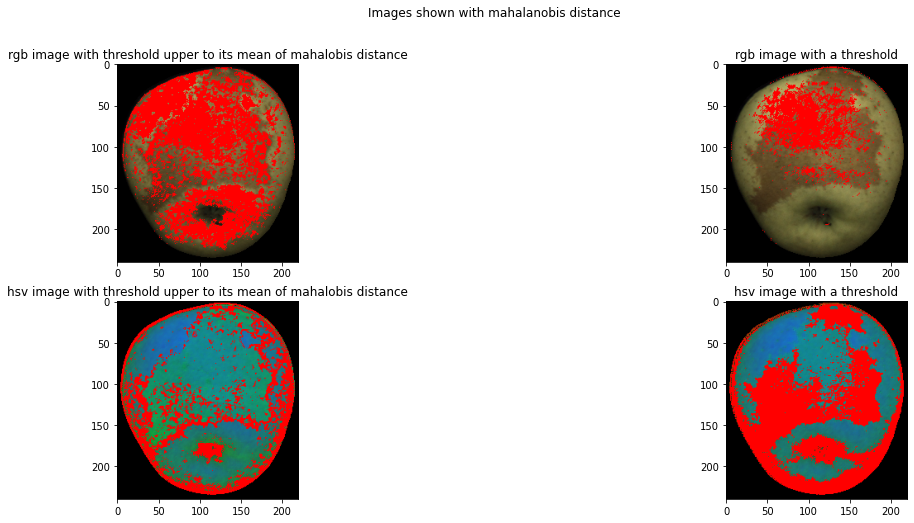

In [133]:
fig = plt.figure(figsize=(20, 8))
m,n = mahala.shape
image_rgb_apple2 = image_rgb[1].copy()
image_rgb_apple2_hsv = image_hsv[1].copy()
image_rgb_apple2_russet = image_rgb[1].copy()
image_rgb_apple2_russet_hsv = image_hsv[1].copy()
for j in range(0,m):
    if mahala[j,0]> mean:
        image_rgb_apple2[k_ind[j],l_ind[j],0:3] = [255,0,0]
    if ((mahala_russet[j,0] < 31000) and (mahala_russet[j,0] > 27000)):
        image_rgb_apple2_russet[k_ind[j],l_ind[j],0:3] = [255,0,0]
    if mahala[j,0]< 2000:
        image_rgb_apple2_hsv[k_ind_hsv[j],l_ind_hsv[j],0:3] = [255,0,0]
    if mahala_russet_hsv[j,0] > mean_russet_hsv:
        image_rgb_apple2_russet_hsv[k_ind_hsv[j],l_ind_hsv[j],0:3] = [255,0,0]

plt.subplot(2,2,1)
plt.title("rgb image with threshold upper to its mean of mahalobis distance")
plt.imshow(image_rgb_apple2)
plt.subplot(2,2,2)
plt.title("rgb image with a threshold")
plt.imshow(image_rgb_apple2_russet)
plt.subplot(2,2,3)
plt.title("hsv image with threshold upper to its mean of mahalobis distance")
plt.imshow(image_rgb_apple2_hsv)
plt.subplot(2,2,4)
plt.title("hsv image with a threshold")
plt.imshow(image_rgb_apple2_russet_hsv)
fig.suptitle("Images shown with mahalanobis distance")
plt.show()

## Eucledian Distance

In [74]:
dist_e = []
image_apple_e0 = []
k_ind_e0= []
l_ind_e0 = []
m,n,channels = image_rgb[0].shape 
for k in range (0,m):
    for l in range(0,n):  
        if any(image_rgb[0][k,l,0:3]>20): #with this condition we can consider only the apple without the background
            image_apple_e0.append(image_rgb[0][k,l,0:3])
            k_ind_e0.append(k)
            l_ind_e0.append(l)
            #eucledian distance
            dist_e.append(np.sqrt(np.matmul(np.subtract(image_rgb[0][k,l,0:3] , color_means[0]).reshape(1,-1) , np.subtract(image_rgb[0][k,l,0:3] , color_means[0])))) 
eucledian_0 = np.array(dist_e)
mean_e0 = eucledian_0.mean()
image_apple_e0 = np.array(image_apple_e0)
print("eucledian distance: \n", eucledian_0)
print("\n mean of eucledian distance: \n", mean_0)

eucledian distance: 
 [[143.4179047 ]
 [139.56530156]
 [141.96802793]
 ...
 [ 12.796555  ]
 [ 11.226616  ]
 [ 12.57865764]]

 mean of eucledian distance: 
 223.60476142033133


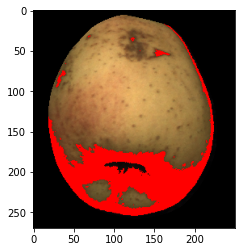

In [79]:
m,n = eucledian_0.shape
image_rgb_apple_e0 = image_rgb[0].copy()
for j in range(0,m):
    if eucledian_0[j,0]<70:
        image_rgb_apple_e0[k_ind_e0[j],l_ind_e0[j],0:3] = [255,0,0]

plt.imshow(image_rgb_apple_e0)
plt.show()

In [137]:
dist_e = []
dist_e_russet = []
image_apple_e = []
k_ind_e= []
l_ind_e = []
m,n,channels = image_rgb[1].shape 
for k in range (0,m):
    for l in range(0,n):  
        if any(image_rgb[1][k,l,0:3]): #with this condition we can consider only the apple without the background
            image_apple_e.append(image_rgb[1][k,l,0:3])
            k_ind_e.append(k)
            l_ind_e.append(l)
            #eucledian distance
            dist_e.append(np.sqrt(np.matmul(np.subtract(image_rgb[1][k,l,0:3] , color_means[1]).reshape(1,-1) , np.subtract(image_rgb[1][k,l,0:3] , color_means[1]))))
            dist_e_russet.append(np.sqrt(np.matmul(np.subtract(image_rgb[1][k,l,0:3] , color_means_russet).reshape(1,-1) , np.subtract(image_rgb[1][k,l,0:3] , color_means_russet)))) 

eucledian = np.array(dist_e)
eucledian_russet = np.array(dist_e_russet)
mean_e = eucledian.mean()
mean_e_russet = eucledian_russet.mean() 
image_apple_e = np.array(image_apple_e)

print("eucledian distance: \n", eucledian)
print("\n mean of eucledian distance: \n", mean_e)

print("eucledian distance: \n", eucledian_russet)
print("\n mean of eucledian distance: \n", mean_e_russet)



eucledian distance: 
 [[139.19412961]
 [139.51261947]
 [141.17186481]
 ...
 [106.2524747 ]
 [110.33919346]
 [106.96823757]]

 mean of eucledian distance: 
 38.471055697932194
eucledian distance: 
 [[218.71671175]
 [219.41285286]
 [221.11761576]
 ...
 [191.44189719]
 [194.34505396]
 [191.96614285]]

 mean of eucledian distance: 
 118.68858595800617


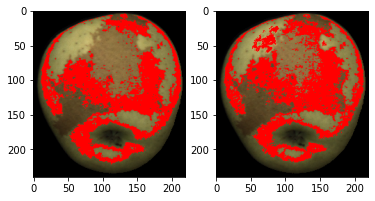

In [142]:
m,n = eucledian.shape
image_rgb_apple_e = image_rgb[1].copy()
image_rgb_apple_e_russet = image_rgb[1].copy()
for j in range(0,m):
    if eucledian[j,0]<20:
        image_rgb_apple_e[k_ind_e[j],l_ind_e[j],0:3] = [255,0,0]
    if ((eucledian_russet[j,0] >100 ) and (eucledian_russet[j,0] <120)) : 
        image_rgb_apple_e_russet[k_ind_e[j],l_ind_e[j],0:3] = [255,0,0]

plt.subplot(1,2,1)        
plt.imshow(image_rgb_apple_e)
plt.subplot(1,2,2)  
plt.imshow(image_rgb_apple_e_russet)
plt.show()

## Task 3: Kiwi Inspection

In [42]:
# Set some constants needed in the code

FILENAMES3 = ["000006","000007","000008","000009","000010"]
N3 = len(FILENAMES3)

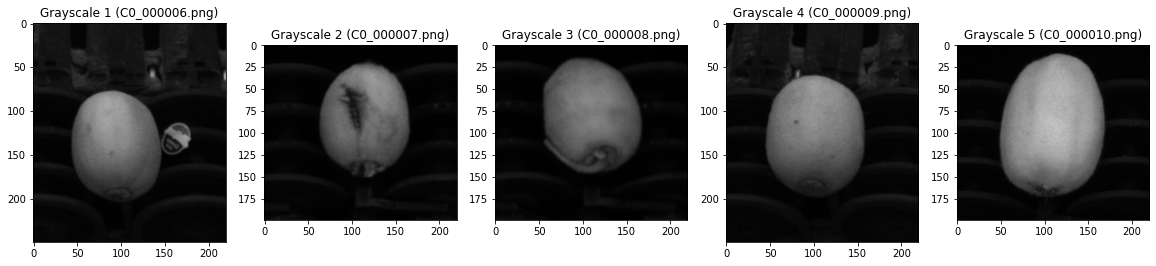

In [43]:
grayscales3 = []
plt.figure(figsize=(20, 5))

for i, name in enumerate(FILENAMES3):
    img = cv2.imread("img/final challenge/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales3.append(img)
    plt.subplot(1,N3,i+1)
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

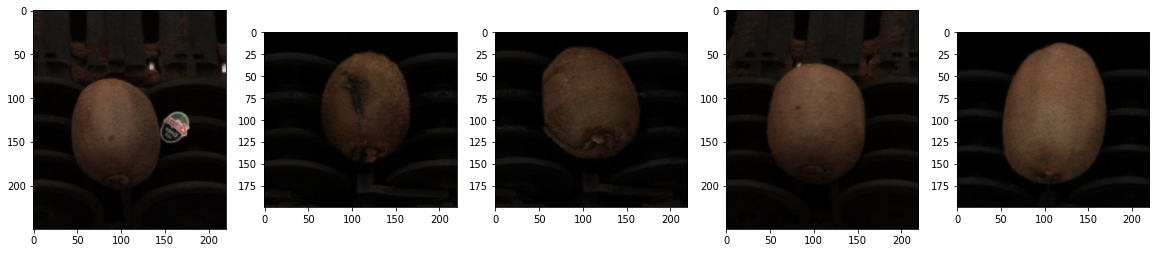

In [44]:
rgb3 = []
plt.figure(figsize=(20, 5))
for i, name in enumerate(FILENAMES3):
    img_bgr = cv2.imread("img/final challenge/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb3.append(img_rgb)
    plt.subplot(1,N3,i+1)
    plt.imshow(img_rgb)
plt.show()

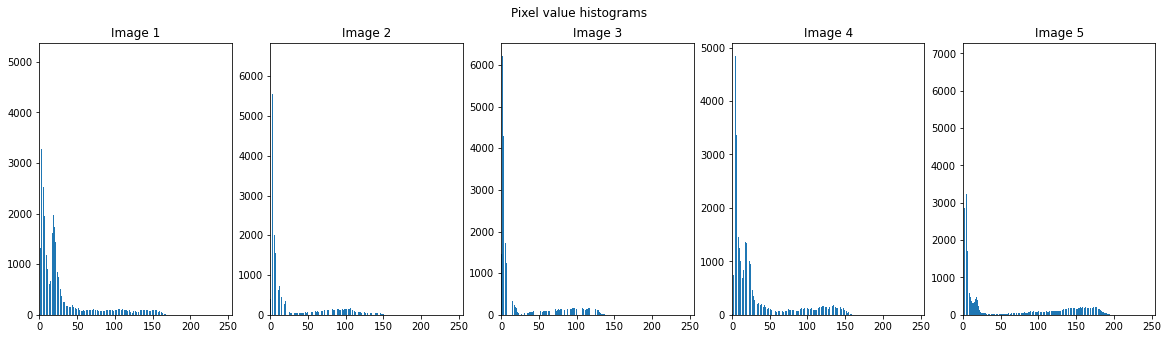

In [45]:
fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales3):
    # flatten to 1D array
    vals_3 = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N3,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals_3, 255)
    plt.xlim([0,255])
fig.suptitle("Pixel value histograms")
plt.show()

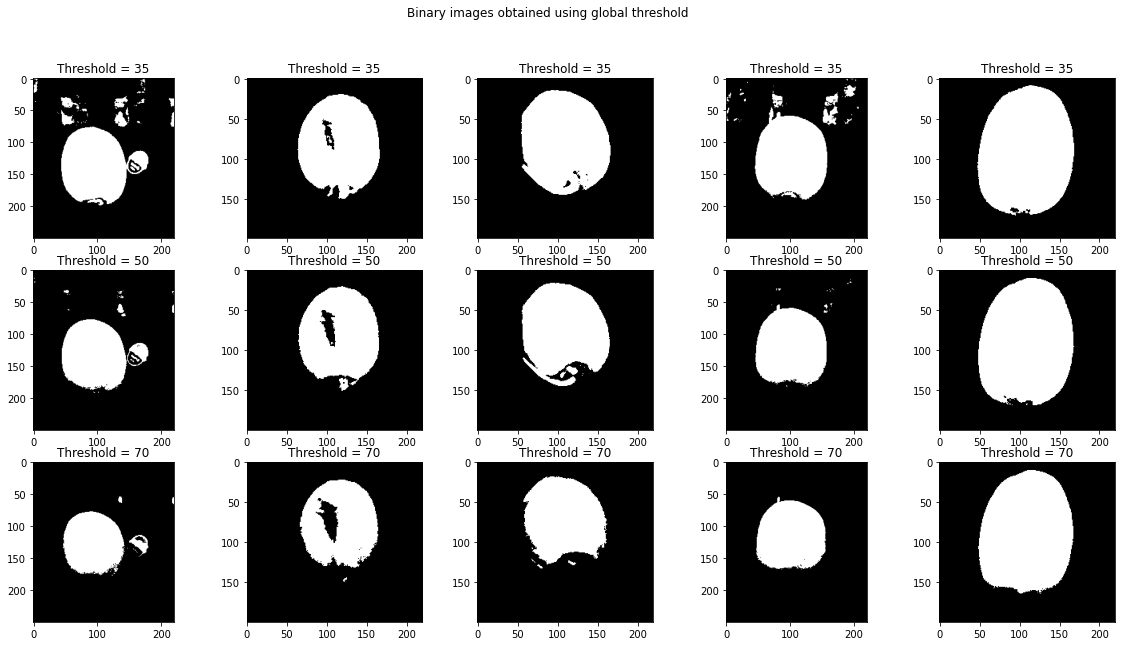

In [46]:
masks3 = []
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(grayscales3):
    # TODO per Vale: spiegare come si è ottenuto threshold uguale a 40 (osservazione istogramma + tentativi),
    # mostrare i risultati con altre threshold, spiegare perché otsu non va bene (il bg "mangia" il fg)
    # aggiungere i titolo al grafico
    ret,thresh = cv2.threshold(img,  35, 1, cv2.THRESH_BINARY)
    ret,thresh1 = cv2.threshold(img, 50, 1, cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(img, 70, 1, cv2.THRESH_BINARY)
    masks3.append(thresh1)
    
    a = fig.add_subplot(3,5, i+1)
    a.set_title('Threshold = 35')
    plt.imshow(thresh, 'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,5,i+6)
    a.set_title('Threshold = 50')
    plt.imshow(thresh1 ,'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,5,i+11)
    a.set_title('Threshold = 70')
    plt.imshow(thresh2 , 'gray' ,vmin=0, vmax=1)
fig.suptitle("Binary images obtained using global threshold")
plt.show()

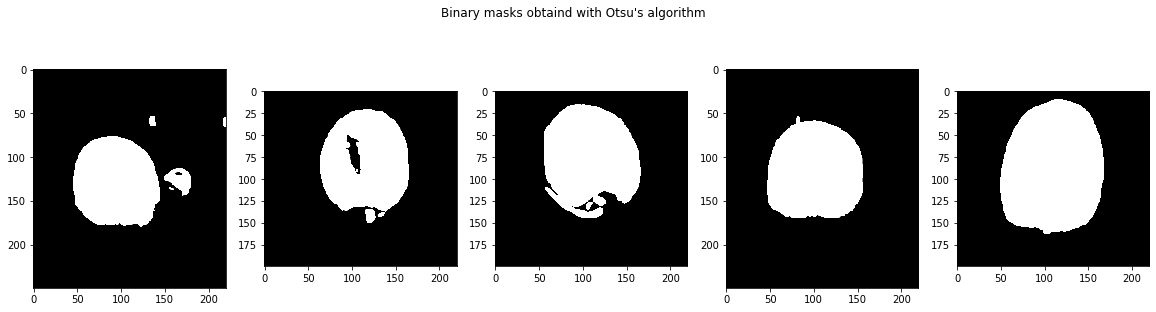

In [66]:
otsu_masks_3 = []

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales3):
    # (1,1) => no blur
    blur3 = cv2.GaussianBlur(img,(3,3),0)
    ret3, mask3 = cv2.threshold(blur3, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsu_masks_3.append(mask3)
    plt.subplot(1,N3,i+1)
    plt.imshow(mask3, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

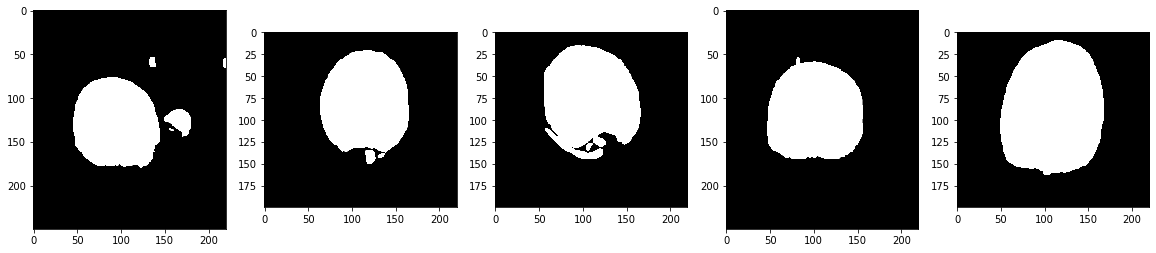

In [69]:
### Flood-fill
ff_masks3 = []
fig = plt.figure(figsize=(20, 5))
for k, mask3 in enumerate(otsu_masks_3):
    mask_floodfill = mask3.copy()
    cv2.floodFill(mask_floodfill, None, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(mask_floodfill)
    im_out = mask3 | im_floodfill_inv
    plt.subplot(1,5,k+1)
    plt.imshow(im_out, cmap='gray', vmin=0, vmax=1)
plt.show()